In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sys.path.append('..')
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
np.random.seed(247)
tf.set_random_seed(247)

In [2]:

data_path = '../../data/RNAcompete_2013/rnacompete2013.h5'
experiments = helper.get_experiments_hdf5(data_path)


In [3]:
rbp_index = 69
ss_type = 'seq'
normalize_method = 'log_norm'

# load rbp dataset
train, valid, test = helper.load_dataset_hdf5(data_path, dataset_name=None, ss_type=ss_type, rbp_index=rbp_index)

# process rbp dataset
train, valid, test = helper.process_data(train, valid, test, method=normalize_method)
 

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


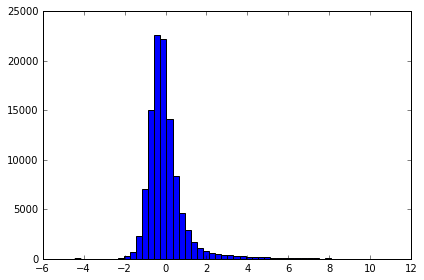

In [4]:
plt.hist(train['targets'][:,0], bins=50);

In [5]:
# set output file paths
model = 'affinity_residualbind'
genome_model = helper.import_model(model)
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape
model_layers, optimization = genome_model.model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)
nnmodel.inspect_layers()

# compile neural trainer
results_path = helper.make_directory('../../test', 'RNAcompete_2013')
save_path = helper.make_directory(results_path, normalize_method+'_'+ss_type)
file_path = os.path.join(save_path, str(rbp_index)+'_'+model+'_'+ss_type)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 192)
layer17: conv1d_1_batch
(?, 1, 1, 192)
layer18: conv1d_1_active
(?, 1, 1, 192)
layer19: conv1d_1_dropout


In [6]:
# initialize session
sess = utils.initialize_session()

In [7]:
# fit data
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, batch_size=100, num_epochs=100, 
                      patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- time=14s -- loss=1.07840 
  valid loss:		0.74727
  valid Pearson's R:	0.62852+/-0.00000
  valid rsquare:	0.29693+/-0.00000
  valid slope:		1.61541+/-0.00000
  lower cross-validation found
  saving model to:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residualbind_seq_best.ckpt
Epoch 2 out of 100 
[===============               ] 49.9% -- time=7s -- loss=0.70732

KeyboardInterrupt: 

In [8]:
# load best model
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, batch_size=128, name='test', verbose=1)

loading model from:  ../../test/RNAcompete_2013/log_norm_seq/69_affinity_residual_net_seq_best.ckpt
  test  loss:		0.35764
  test  Pearson's R:	0.80444+/-0.00000
  test  rsquare:	0.64627+/-0.00000
  test  slope:		0.98203+/-0.00000


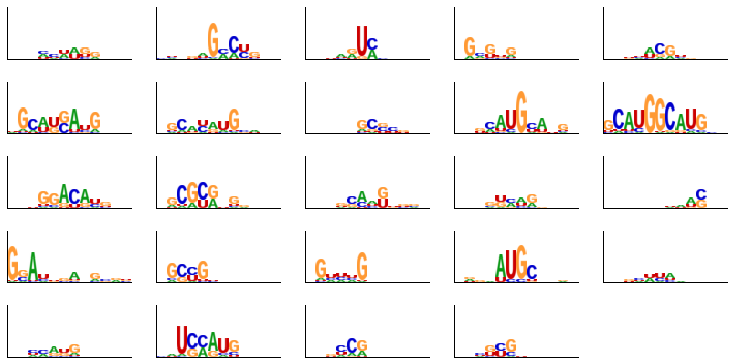

In [10]:
# plot filters
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
fig, plt = visualize.plot_filter_logos(W[:,:,:4,:], figsize=(100,50), height=25, nt_width=10, norm=0, alphabet='rna')
#outfile = os.path.join(save_path, 'conv1_filters.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
#plt.close()

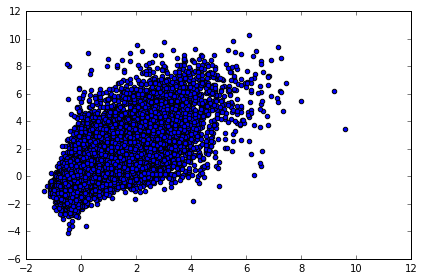

In [11]:
predictions = nntrainer.get_activations(sess, test, layer='output')
plt.scatter(predictions, test['targets'])
#outfile = os.path.join(save_path, 'test_scatter.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
#plt.close()

INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_pu/69_affinity_conv_net_pu_best.ckpt


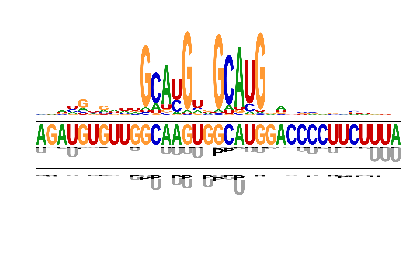

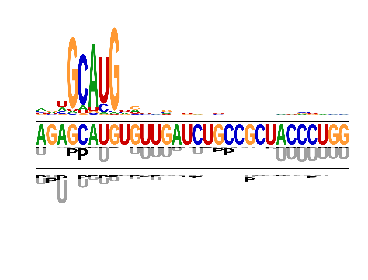

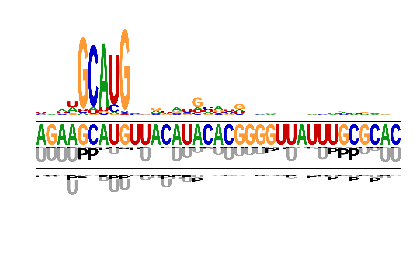

In [227]:
num_plots = 3
max_indices = np.argsort(predictions[:,0])[::-1]  
plot_range = range(0,num_plots)
plot_index = max_indices[510:513]
X = test['inputs'][plot_index]

# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)
    
for i in range(num_plots):
  
    # plot saliency comparison
    fig = plt.figure()
    plt = visualize.plot_seq_struct_saliency(np.squeeze(X)[i].T, np.squeeze(guided_saliency[i]).T, nt_width=100, norm_factor=3)
    
    #output_name = '{:.2f}'.format(predictions[i,0]) + '_' + '{:.2f}'.format(data['targets'][i,0])
    #outfile = os.path.join(save_path, output_name+'.pdf')
    #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
    #plt.close()

In [228]:
plot_index

array([22084, 21072, 94891])

In [229]:
plot_index = 21072#48173# 36085#22084
X = np.expand_dims(test['inputs'][plot_index], axis=0)

INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_pu/69_affinity_conv_net_pu_best.ckpt


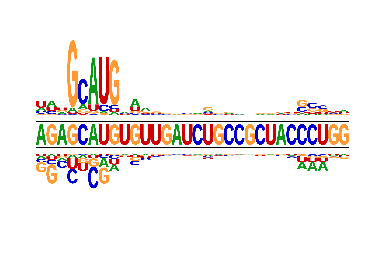

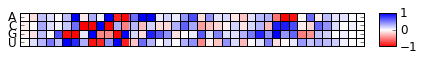

In [275]:
# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.backprop(X, layer='output', class_index=0, params=params)
    
# plot saliency comparison
fig = plt.figure()
#plt = visualize.plot_seq_struct_saliency(np.squeeze(X).T, np.squeeze(guided_saliency).T, nt_width=100, norm_factor=3)
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], np.squeeze(guided_saliency).T[:4,:], nt_width=100, norm_factor=3, alphabet='rna')


plt.figure()
W = np.squeeze(guided_saliency).T[:4,:]
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])


INFO:tensorflow:Restoring parameters from ../../test/RNAcompete_2013/log_norm_pu/69_affinity_conv_net_pu_best.ckpt


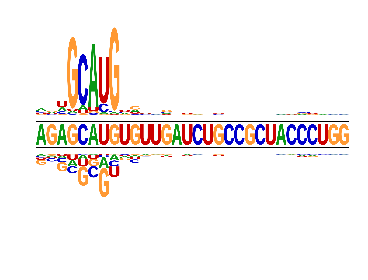

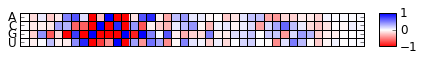

In [276]:
# parameters for saliency analysis
params = {'genome_model': genome_model.model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': file_path+'_best.ckpt',
          'optimization': optimization
         }

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)
    
# plot saliency comparison
fig = plt.figure()
#plt = visualize.plot_seq_struct_saliency(np.squeeze(X).T, np.squeeze(guided_saliency).T, nt_width=100, norm_factor=3)
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], np.squeeze(guided_saliency).T[:4,:], nt_width=100, norm_factor=3, alphabet='rna')



plt.figure()
W = np.squeeze(guided_saliency).T[:4,:]
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])


In [300]:
mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(X)
        x[0,j,0,:4] = 0
        x[0,j,0,i] = 1
        mutations.append(x)
mutations = np.vstack(mutations)
        
    
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': X})

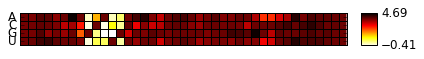

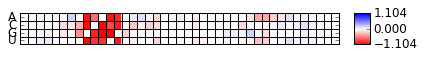

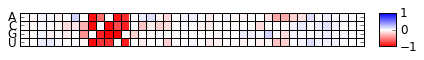

In [301]:


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1
        
mutagenesis_norm = mutagenesis/baseline[0] - 1
MAX = np.max(np.abs(mutagenesis_norm))
mutagenesis_rescale = mutagenesis_norm/MAX



plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])


plt.figure()
W = mutagenesis_norm.T
MAX = np.max(np.abs(W))
norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-MAX, 0., MAX])


plt.figure()
W = mutagenesis_rescale.T
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])


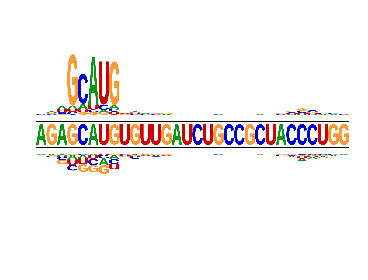

In [302]:

# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')


In [309]:
epsilon = 0.01
mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(X)
        x[0,j,0,i] += epsilon
        mutations.append(x)
mutations = np.vstack(mutations)
        
    
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': X})

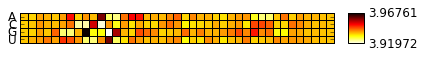

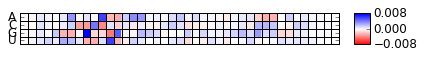

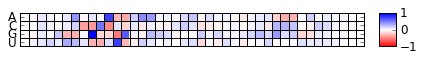

In [310]:
mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1
        
mutagenesis_norm = mutagenesis/baseline[0] - 1
mutagenesis_rescale = mutagenesis_norm/np.max(mutagenesis_norm)



plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])


plt.figure()
W = mutagenesis_norm.T
MAX = np.max(np.abs(W))
norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-MAX, 0., MAX])


plt.figure()
W = mutagenesis_rescale.T
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])



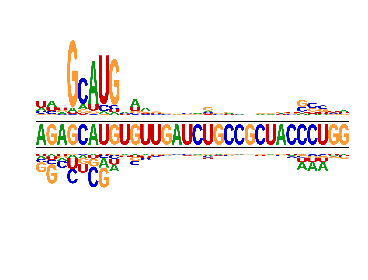

In [311]:
# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')

In [312]:
epsilon = .01
mutations = []
for j in range(X.shape[1]):
    for i in range(4):
        x = np.copy(X)
        x[0,j,0,:4] = 0
        x[0,j,0,i] = 1+epsilon
        mutations.append(x)
mutations = np.vstack(mutations)
        
    
activations = nntrainer.get_activations(sess, {'inputs': mutations})
baseline = nntrainer.get_activations(sess, {'inputs': X})

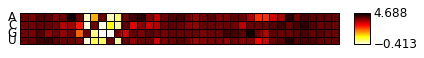

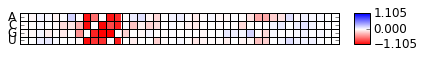

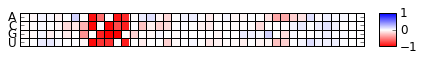

In [313]:
mutagenesis = np.zeros((X.shape[1], 4))
k = 0
for j in range(X.shape[1]):
    for i in range(4):
        mutagenesis[j,i] = activations[k,0]
        k += 1
        
mutagenesis_norm = mutagenesis/baseline[0] - 1
mutagenesis_rescale = mutagenesis_norm/np.max(np.abs(mutagenesis_norm))



plt.figure()
W = mutagenesis.T
MAX = np.max(W)
MIN = np.min(W)
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='hot_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([MIN, MAX])


plt.figure()
W = mutagenesis_norm.T
MAX = np.max(np.abs(W))
norm = matplotlib.colors.Normalize(vmin=-MAX, vmax=MAX)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-MAX, 0., MAX])


plt.figure()
W = mutagenesis_rescale.T
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
im = plt.imshow(W, interpolation='none', cmap='bwr_r', norm=norm)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, W.shape[1], 1.), minor=True);
ax.set_yticks(np.arange(-.5, W.shape[0], 1.), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
plt.xticks([]);
plt.yticks([])
if W.shape[0] == 4:
    plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=12)
else:
    plt.yticks([0, 1, 2, 3, 4, 5], ['A', 'C', 'G', 'U', 'paired', 'unpaired'], fontsize=12)
#cbar = plt.colorbar();
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([-1.0, 0., 1.0])


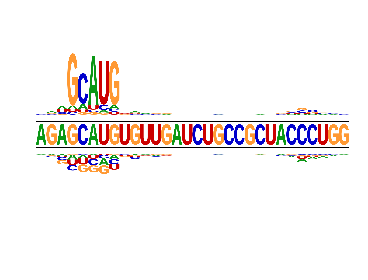

In [314]:
# plot saliency comparison
fig = plt.figure()
plt = visualize.plot_seq_neg_saliency(np.squeeze(X).T[:4,:], mutagenesis_rescale.T, nt_width=100, norm_factor=3, alphabet='rna')